In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Dialogflow CX NLU Migration Side-by-Side Evaluation

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/contact-center-ai-samples/blob/main/nlu-evaluation/nlu_evaluation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/contact-center-ai-samples/blob/main/nlu-evaluation/nlu_evaluation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/contact-center-ai-samples/blob/main/nlu-evaluation/nlu_evaluation.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This notebook is to help users evaluate the performance of the Advanced NLU (aNLU) compared to the Standard NLU (sNLU).

  - [Dialogflow CX > Agents > ML Settings > NLU Type](https://cloud.google.com/dialogflow/cx/docs/concept/agent#nlu-type)

Run "Implementation" section.

For each eval that you would run, fill agent details in "Fill & Run" section and run it.

On the first run, colab will prompt you to authenticate with your account to get access to Dialogflow agents and spreadsheets. Credentials will be saved for subsequent evaluation runs.


## Dataset

Must contain following columns (can contain other columns that won't be affected):
- `Flow Display Name`: Display name of the flow where utterance will be evaluated, e.g. Default Start Flow.
- `Page Display Name`: Display name of the page in the chosen flow where utterance will be evaluated, e.g. Start Page.
- `Utterance`: Utterance which will be evaluated.
- `Expected Intent`: Expected intent display name for the utterance.
- `Frequency`: Optional column to calculate weighted accuracy. If column does not exist, frequency is assumed to be 1 for each utterance.

After execution, following columns will be added to the same worksheet for each agent label:
- `Detected Intent <agent_label>`: Intent matched by Dialogflow.
- `Confidence <agent_label>`: Intent score.
- `Passed <agent_label>`: PASS or FAIL depending if expected intent is the same as detected intent.

## Summary

Worksheet will be created by the script if it does not exist. On the first run, either let the script create a worksheet or use an empty one.

Columns populated by the script:
- `UTC Timestamp`: Timestamp when evaluation started.
- `Dataset tab`: Which worksheet was used for this evaluation.
- `Agent label`: Label of the agent which was used for this evaluation.
- `Utterances`: Amount of utterances in the dataset.
- `Passed`: Amount of utterances that matched expected intent.
- `Passed %`: Percentage of utterances that matched expected intent.
- `No-match`: Amount of utterances that didn't match any intent.
- `No-match %`: Percentage of utterances that didn't match any intent.


## Example

Here is an example how your spreadsheet would look like before running this colab:

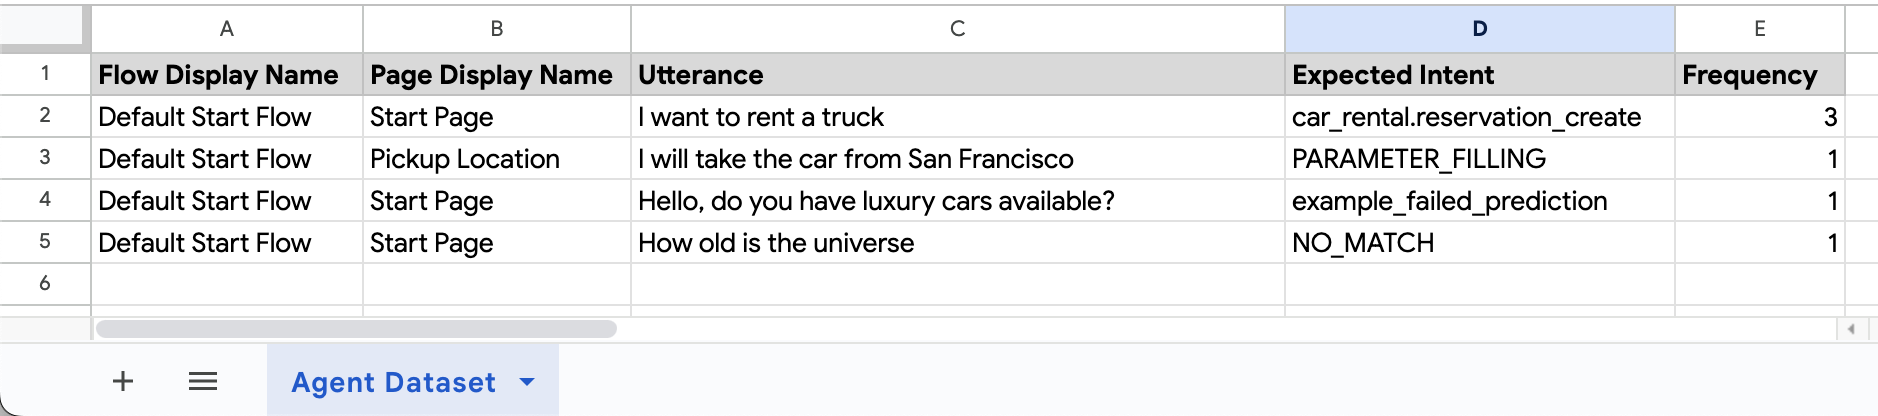

And here is how it would look like after running the colab:


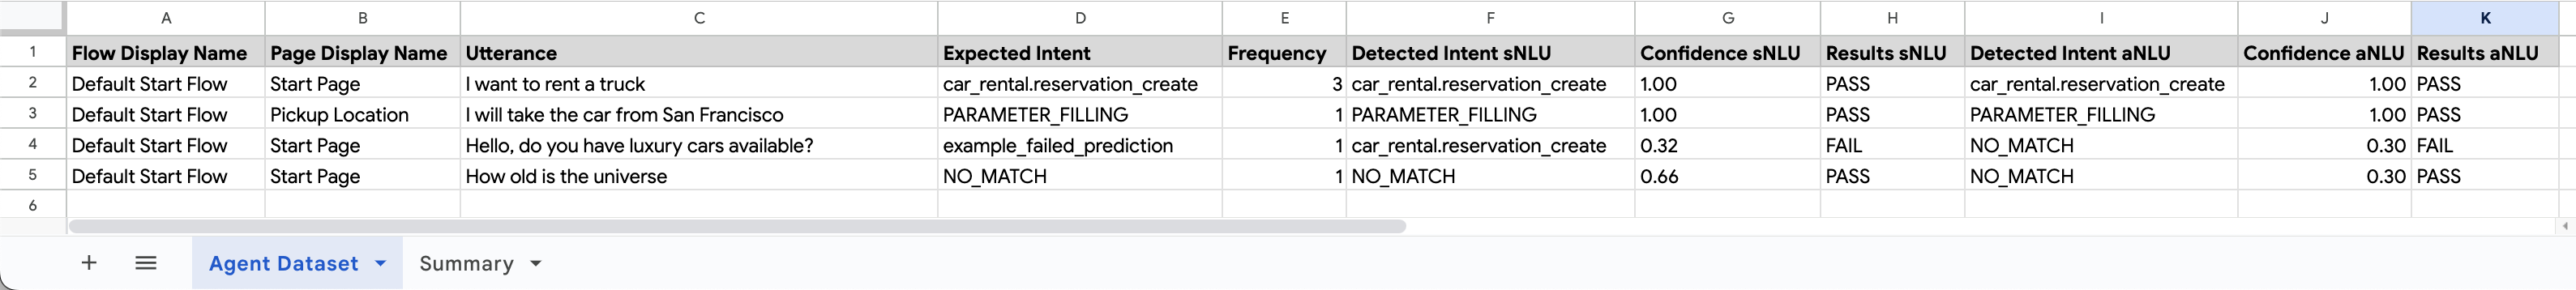

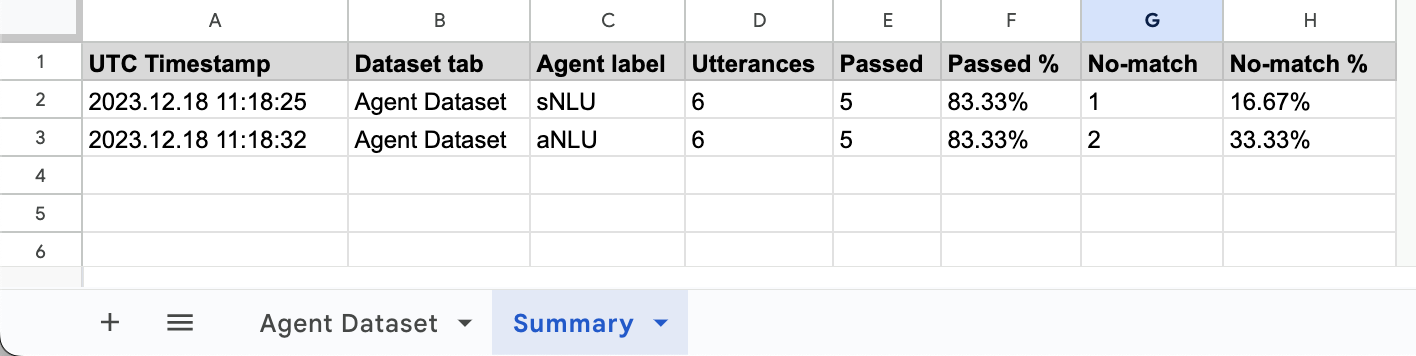

# Implementation

In [ ]:
!pip3 install --upgrade gspread --quiet
!pip3 install --upgrade google-cloud-dialogflow-cx --quiet
!pip3 install --upgrade ratelimit --quiet

In [ ]:
from google.colab import auth
from google.auth import default
import gspread

import datetime
import pandas as pd
import numpy as np
import uuid
import ratelimit
from concurrent.futures import ThreadPoolExecutor, as_completed
import sys
from functools import lru_cache


from typing import Union, Any

from google.cloud.dialogflowcx_v3.services.agents import AgentsClient
from google.cloud.dialogflowcx_v3.services.flows import FlowsClient
from google.cloud.dialogflowcx_v3.services.pages import PagesClient
from google.cloud.dialogflowcx_v3.services.sessions import SessionsClient
from google.cloud.dialogflowcx_v3.types import session

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Constants.

dataset_columns = ['Flow Display Name', 'Page Display Name', 'Utterance', 'Expected Intent']
dataset_added_columns = ['Detected Intent {}', 'Confidence {}', 'Passed {}']

summary_rows = 100
summary_columns = ['UTC Timestamp', 'Dataset tab', 'Agent label', 'Utterances', 'Passed', 'Passed %', 'No-match', 'No-match %']

# No more than 10 QPS for DetectIntent
ONE_SECOND = 1
MAX_CALLS = 10

In [ ]:
def setup_spreadsheet(spreadsheet_client: gspread.Client, spreadsheet_url: str, dataset_tab: str, summary_tab: str) -> tuple[dict[str, Any], pd.DataFrame]:
  '''Gets spreadsheet info, dataset and sets up worksheets.'''
  info = {
      'spreadsheet': None,
      'dataset_worksheet': None,
      'summary_worksheet': None,
  }

  info['spreadsheet'] = spreadsheet_client.open_by_url(spreadsheet_url)

  # Dataset tab must exist.
  info['dataset_worksheet'] = info['spreadsheet'].worksheet(dataset_tab)

  # Summary tab can be created.
  try:
    info['summary_worksheet'] = info['spreadsheet'].worksheet(summary_tab)
  except gspread.exceptions.WorksheetNotFound as e:
    print(f'Worksheet `{summary_tab}` does not exist. Creating...')
    info['summary_worksheet'] = info['spreadsheet'].add_worksheet(summary_tab, rows=summary_rows, cols=len(summary_columns))

  if not info['summary_worksheet'].get_all_values():
    print('Summary worksheet is empty. Initializing...')
    cell_list = info['summary_worksheet'].range(f'A1:{chr(ord("A") + len(summary_columns) - 1)}1')
    for i, cell in enumerate(cell_list):
      cell.value = summary_columns[i]
    info['summary_worksheet'].update_cells(cell_list)


  # Dataset load.
  dataset = info['dataset_worksheet'].get_all_values()
  dataset = pd.DataFrame(dataset[1:], columns=dataset[0])

  validate_worksheet(dataset, dataset_columns)
  dataset = cleanup_dataset(dataset)

  if "Frequency" in dataset.columns:
    dataset['Frequency'] = dataset['Frequency'].apply(lambda x: 1 if not x else x).astype(int)

  return info, dataset

def validate_worksheet(dataset: pd.DataFrame, columns: list[str]) -> None:
  '''Raises ValueError if worksheet does not contain required columns.'''
  for column in columns:
    if not column in dataset.columns:
      raise ValueError(f'Column `{column}` does not exist in the worksheet. Columns: {list(dataset.columns)}.')

def cleanup_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
  '''Removes spaces around string columns.'''
  return dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)


def get_api_endpoint(region: str) -> str:
  '''Returns DF CX API endpoint based on region.'''
  if region == 'global':
    return 'dialogflow.googleapis.com:443'
  return f'{region}-dialogflow.googleapis.com:443'

def get_session_client(region: str) -> SessionsClient:
  '''Returns DF CX SessionsClient based on region.'''
  api_endpoint = get_api_endpoint(region)
  print(f"Using API endpoint `{api_endpoint}`")
  return SessionsClient(client_options={'api_endpoint': api_endpoint})

def get_flow_client(region: str) -> FlowsClient:
  '''Returns DF CX FlowsClient based on region.'''
  api_endpoint = get_api_endpoint(region)
  return FlowsClient(client_options={'api_endpoint': api_endpoint})

def get_page_client(region: str) -> PagesClient:
  '''Returns DF CX PageClient based on region.'''
  api_endpoint = get_api_endpoint(region)
  return PagesClient(client_options={'api_endpoint': api_endpoint})


@ratelimit.sleep_and_retry
@ratelimit.limits(calls=MAX_CALLS, period=ONE_SECOND)
def detect_intent(
    session_client: SessionsClient,
    project_id: str,
    region: str,
    agent_id: str,
    language_code: str,
    flow_id: str,
    page_id: str,
    utterance: str) -> tuple[str, float]:
  session_path = f'projects/{project_id}/locations/{region}/agents/{agent_id}/sessions/{uuid.uuid4()}'

  current_page_path = f'projects/{project_id}/locations/{region}/agents/{agent_id}/flows/{flow_id}/pages/{page_id}'

  request = session.DetectIntentRequest(
      session=session_path,
      query_input=session.QueryInput(
        text=session.TextInput(text=utterance),
        language_code=language_code),
      query_params=session.QueryParameters(
          current_page=current_page_path
      )
  )

  response = session_client.detect_intent(request=request)

  detected_intent = response.query_result.intent.display_name or str(response.query_result.match.match_type).replace("MatchType.", "")
  confidence = response.query_result.intent_detection_confidence

  return detected_intent, confidence

def detect_intent_all(
    session_client: SessionsClient,
    project_id: str,
    region: str,
    agent_id: str,
    language_code: str,
    flow_ids: list[str],
    page_ids: list[str],
    utterances: list[str]
) -> tuple[list[str], list[float]]:

  detected_intents = []
  confidences = []

  assert len(flow_ids) == len(page_ids) == len(utterances), "Lists must be of equal length."

  count = len(utterances)

  print('Started evaluation.')
  sys.stdout.flush()
  with ThreadPoolExecutor(max_workers=None) as executor:
    results = executor.map(
        detect_intent,
        [session_client] * count,
        [project_id] * count,
        [region] * count,
        [agent_id] * count,
        [language_code] * count,
        flow_ids,
        page_ids,
        utterances)
    for i, (detected_intent, confidence) in enumerate(results):
      detected_intents.append(detected_intent)
      confidences.append(confidence)
      print(f'\rEvaluated {i + 1} / {count} utterances.', end='')
      sys.stdout.flush()

  print()

  return detected_intents, confidences

@lru_cache(maxsize=None)
def get_flow_ids(flow_client: FlowsClient, project_id: str, region: str, agent_id: str) -> dict[str, str]:
  """Gets flow mapping from flow_display_name to flow_id."""
  flows = flow_client.list_flows(parent=f'projects/{project_id}/locations/{region}/agents/{agent_id}')
  return {flow.display_name.strip(): flow.name.split('/')[-1] for flow in flows}

@ratelimit.sleep_and_retry
@ratelimit.limits(calls=MAX_CALLS, period=ONE_SECOND)
def list_pages(page_client: PagesClient, flow_path: str) -> list:
  return page_client.list_pages(parent=flow_path)

@lru_cache(maxsize=None)
def get_page_ids(page_client: PagesClient, project_id: str, region: str, agent_id: str, flow_ids: str) -> dict[tuple[str, str], str]:
  """Gets page mapping from flow_id, page_display_name to page_id."""
  page_ids = {}
  for flow_id in flow_ids:
     pages = list_pages(page_client, f'projects/{project_id}/locations/{region}/agents/{agent_id}/flows/{flow_id}')
     page_ids.update({(flow_id, page.display_name.strip()): page.name.split('/')[-1] for page in pages})
     page_ids[(flow_id, 'Start Page')] = 'START_PAGE'
     page_ids[(flow_id, 'End Session')] = 'END_SESSION'
  return page_ids


def evaluate_dataset(
    session_client: SessionsClient,
    flow_client: FlowsClient,
    page_client: PagesClient,
    dataset: pd.DataFrame,
    agent_label: str,
    project_id: str,
    region: str,
    agent_id: str,
    language_code: str,
) -> pd.DataFrame:
  """Evaluates datasets and populates new columns inside it."""

  # Map flows
  print('Getting flow mapping...', end='')
  flow_display_name_to_ids = get_flow_ids(flow_client, project_id, region, agent_id)
  dataset['Flow Id'] = dataset['Flow Display Name'].map(flow_display_name_to_ids)
  flow_ids = dataset['Flow Id'].tolist()
  print('done')
  print(f'Found {len(flow_display_name_to_ids)} flows.')

  # Map pages
  print('Getting page mapping...', end='')
  flow_id_page_display_name_to_ids = get_page_ids(page_client, project_id, region, agent_id, flow_display_name_to_ids.values())

  dataset['Page Id'] = dataset.apply(lambda row: flow_id_page_display_name_to_ids[(row['Flow Id'], row['Page Display Name'])], axis=1)
  page_ids = dataset['Page Id'].tolist()
  print('done')


  utterances = dataset['Utterance'].tolist()

  # DetectIntent calls
  detected_intents, confidences = detect_intent_all(
      session_client,
      project_id,
      region,
      agent_id,
      language_code,
      flow_ids,
      page_ids,
      utterances)

  dataset[f'Detected Intent {agent_label}'] = detected_intents
  dataset[f'Confidence {agent_label}'] = confidences

  dataset[f'Results {agent_label}'] = dataset.apply(lambda row: 'PASS' if row['Expected Intent'] == row[f'Detected Intent {agent_label}'] else 'FAIL', axis=1)

  return dataset

def write_summary(summary_worksheet: gspread.Worksheet, dataset: pd.DataFrame, agent_label: str, timestamp: str, dataset_tab: str) -> None:
  """Appends summary of the run to the Summary worksheet."""
  summary = summary_worksheet.get_all_values()
  summary = pd.DataFrame(summary[1:], columns=summary[0])
  validate_worksheet(summary, summary_columns)

  run_values = {c: '' for c in summary.columns }
  run_values['UTC Timestamp'] = timestamp
  run_values['Dataset tab'] = dataset_tab
  run_values['Agent label'] = agent_label
  if "Frequency" in dataset.columns:
    run_values['Utterances'] = sum(dataset['Frequency'])
    run_values['Passed'] = sum(dataset[dataset[f'Results {agent_label}'] == 'PASS']['Frequency'])
    run_values['Passed %'] = sum(dataset[dataset[f'Results {agent_label}'] == 'PASS']['Frequency']) / sum(dataset['Frequency'])
    run_values['No-match'] = sum(dataset[dataset[f'Detected Intent {agent_label}'] == 'NO_MATCH']['Frequency'])
    run_values['No-match %'] = sum(dataset[dataset[f'Detected Intent {agent_label}'] == 'NO_MATCH']['Frequency']) / sum(dataset['Frequency'])
  else:
    run_values['Utterances'] = len(dataset)
    run_values['Passed'] = len(dataset[dataset[f'Results {agent_label}'] == 'PASS'])
    run_values['Passed %'] = len(dataset[dataset[f'Results {agent_label}'] == 'PASS']) / len(dataset)
    run_values['No-match'] = len(dataset[dataset[f'Detected Intent {agent_label}'] == 'NO_MATCH'])
    run_values['No-match %'] = len(dataset[dataset[f'Detected Intent {agent_label}'] == 'NO_MATCH']) / len(dataset)

  summary = pd.concat([summary, pd.DataFrame(run_values, index=[0])], ignore_index=True)

  summary_worksheet.clear()
  summary_worksheet.update(range_name=([summary.columns.values.tolist()] + summary.values.tolist()), values=None)

def write_dataset(dataset_worksheet: gspread.Worksheet, dataset: pd.DataFrame) -> None:
  dataset = dataset.drop(['Flow Id', 'Page Id'], axis=1)

  dataset_worksheet.clear()
  dataset_worksheet.update(range_name=([dataset.columns.values.tolist()] + dataset.values.tolist()), values=None)


def run(
    creds: Any,
    agent_label: str,
    project_id: str,
    region: str,
    agent_id: str,
    language_code: str,
    spreadsheet_url: str,
    dataset_tab: str,
    summary_tab: str,
):
  spreadsheet_client = gspread.Client(creds)
  session_client = get_session_client(region)
  flow_client = get_flow_client(region)
  page_client = get_page_client(region)

  spreadsheet_info, dataset = setup_spreadsheet(spreadsheet_client, spreadsheet_url, dataset_tab, summary_tab)

  timestamp = datetime.datetime.utcnow().strftime('%Y.%m.%d %H:%M:%S')
  dataset = evaluate_dataset(session_client, flow_client, page_client, dataset, agent_label, project_id, region, agent_id, language_code)

  write_dataset(spreadsheet_info['dataset_worksheet'], dataset)
  write_summary(spreadsheet_info['summary_worksheet'], dataset, agent_label, timestamp, dataset_tab)


# Fill & Run

In [ ]:
#@markdown ## Agent #1

agent_label_1 = 'sNLU' #@param {type:"string"}
project_id_1 = 'YOUR_PROJECT_ID' #@param {type:"string"}
region_1 = 'us-central1' #@param {type:"string"}
agent_id_1 = 'YOUR_AGENT_ID' #@param {type:"string"}
language_code_1 = 'en' #@param {type:"string"}

#@markdown &nbsp;

#@markdown If you want to run evaluation just on the first agent, uncheck this checkbox:
use_second_agent = True #@param {type:"boolean"}

#@markdown &nbsp;
#@markdown ## Agent #2

agent_label_2 = 'aNLU' #@param {type:"string"}
project_id_2 = 'YOUR_PROJECT_ID' #@param {type:"string"}
region_2 = 'global' #@param {type:"string"}
agent_id_2 = 'YOUR_AGENT_ID' #@param {type:"string"}
language_code_2 = 'en' #@param {type:"string"}

#@markdown &nbsp;
#@markdown ## Spreadsheet
spreadsheet_url = 'YOUR_SPREADSHEET_LINK' #@param {type:"string"}
dataset_tab = 'Agent Dataset' #@param {type:"string"}
summary_tab = 'Summary' #@param {type:"string"}


auth.authenticate_user(project_id=project_id_1)
creds, _ = default()
print(f"### Running evaluation on agent {agent_label_1} ###\n")
run(creds, agent_label_1, project_id_1, region_1, agent_id_1, language_code_1, spreadsheet_url, dataset_tab, summary_tab)

if use_second_agent:
  auth.authenticate_user(project_id=project_id_2)
  creds, _ = default()
  print(f"\n### Running evaluation on agent {agent_label_2} ###\n")
  run(creds, agent_label_2, project_id_2, region_2, agent_id_2, language_code_2, spreadsheet_url, dataset_tab, summary_tab)


### Running evaluation on agent sNLU ###

Using API endpoint `us-central1-dialogflow.googleapis.com:443`
Getting flow mapping...done
Found 1 flows.
Getting page mapping...done
Started evaluation.
Evaluated 4 / 4 utterances.
